## Centrality Dependence of CNM Effects

### Setup, Import & Preprocess

In [1]:
# --- setup (nPDF only) ---
import os, sys, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pathlib import Path
sys.path.append("./npdf_code")

In [2]:
from npdf_data   import NPDFSystem, RpAAnalysis
from gluon_ratio import EPPS21Ratio, GluonEPPSProvider
# optional (for centrality weights/⟨α⟩)
from glauber     import OpticalGlauber, SystemSpec

In [3]:
# I/O
pPb5_dir = "./input/npdf/pPb5TeV"
pPb8_dir = "./input/npdf/pPb8TeV"
epps_dir = "./input/npdf/nPDFs"
outdir   = Path("./output-npdf-test"); outdir.mkdir(exist_ok=True)

# energies & σ_NN (mb)
SQRTS   = { "5.02": 5023.0, "8.16": 8160.0 }
SIG_NN  = { "5.02": 67.0,   "8.16": 71.0 }
CENT_EDGES = [0,20,40,60,80,100]      # centrality bins (%)
Y_RANGES_THREE = [(-4.46,-2.96), (-1.37,0.43), (2.03,3.53)]  # Back, Mid, For
Y_LABELS       = ["-4.46 < y < -2.96", "-1.37 < y < 0.43", "2.03 < y < 3.53"]
PT_RANGE   = (0.0, 20.0)

In [4]:
def load_R0_sampler(pPb_dir):
    """
    Returns:
      yg, ptg: 1D arrays (grid points)
      R_sets: (49, Ngrid) array with set order: [central, err2, err3, ..., err49]
      r0_at(y_vec, pt_vec): NN sampler → (49, Npoints)
    """
    ana = RpAAnalysis()
    sys = NPDFSystem.from_folder(pPb_dir, kick="pp")

    r = ana.compute_rpa_grid(sys.df_pp, sys.df_pa, sys.df_errors, join="intersect")

    # Case A: tuple like (base_df, r_central, members_48xN)
    if isinstance(r, tuple) and len(r) >= 3:
        base, r0c, mem = r[0], np.asarray(r[1], float), np.asarray(r[2], float)
        yg  = base["y"].to_numpy(float)
        ptg = base["pt"].to_numpy(float)
        R_sets = np.vstack([r0c[None, :], mem])  # (49, Ngrid)

    # Case B: DataFrame with columns ["y","pt","r_central","m2",...,"m49"]
    else:
        df = r if isinstance(r, pd.DataFrame) else pd.DataFrame(r)
        yg  = df["y"].to_numpy(float)
        ptg = df["pt"].to_numpy(float)
        cols = [c for c in df.columns if c.lower().startswith("m")]  # m2..m49
        cols = sorted(cols, key=lambda c: int(''.join(filter(str.isdigit,c)) or 0))
        R_sets = np.vstack([df["r_central"].to_numpy(float)[None, :],
                            df[cols].to_numpy(float).T])  # (49, Ngrid)

    def r0_at(yv, pv):
        yv = np.asarray(yv, float); pv = np.asarray(pv, float)
        idx = np.array([np.argmin((yg-yi)**2 + (ptg-pi)**2) for yi,pi in zip(yv,pv)], int)
        return R_sets[:, idx]  # (49, Npoints)

    return yg, ptg, R_sets, r0_at

In [5]:
# Build R0 samplers
yg5, ptg5, Rsets5, R0_5 = load_R0_sampler(pPb5_dir)
yg8, ptg8, Rsets8, R0_8 = load_R0_sampler(pPb8_dir)

In [6]:
def make_provider(sqrts):
    return GluonEPPSProvider(
        EPPS21Ratio(A=208, path=epps_dir),
        sqrt_sNN_GeV=sqrts, m_state_GeV="charmonium", y_sign_for_xA=-1
    )

prov5 = make_provider(SQRTS["5.02"])
prov8 = make_provider(SQRTS["8.16"])

def K_sets_at_b(provider, b_fm, y_vec, pt_vec):
    """
    Vectorized K for all 49 sets at fixed b.
    Returns (49, Npoints) for inputs y_vec, pt_vec (same length).
    """
    y_vec = np.asarray(y_vec, float); pt_vec = np.asarray(pt_vec, float)
    out = np.empty((49, y_vec.size), float)
    for sid in range(1, 50):  # 1..49
        SA  = provider.SA_ypt_set( y_vec, pt_vec, set_id=sid, flav="g")
        SAW = provider.SAWS_ypt_b_set(y_vec, pt_vec, b_fm,  set_id=sid, flav="g")
        out[sid-1] = SAW / np.clip(SA, 1e-15, None)
    return out

In [7]:
def RpA_table(energy="5.02",
              y_grid=np.linspace(-5,5,41),
              pt_grid=np.linspace(0,20,41),
              b_grid=np.linspace(0,10,21)):
    # pick energy-specific pieces
    R0  = R0_5 if energy=="5.02" else R0_8
    prov= prov5 if energy=="5.02" else prov8

    Y, PT = np.meshgrid(y_grid, pt_grid, indexing="ij")
    yv, pv = Y.ravel(), PT.ravel()                   # N = Ny*Np

    R0_all = R0(yv, pv)                              # (49, N)
    Nb, Ny, Np = len(b_grid), len(y_grid), len(pt_grid)
    R = np.empty((49, Nb, Ny, Np), float)            # set, b, y, pt

    for ib, b in enumerate(b_grid):
        K = K_sets_at_b(prov, b, yv, pv)             # (49, N)
        R[:, ib, :, :] = (R0_all * K).reshape(49, Ny, Np)

    return dict(energy=energy, y=y_grid, pt=pt_grid, b=b_grid, R=R)

In [8]:
# Build raw tables (no averaging yet)
raw5 = RpA_table("5.02")
raw8 = RpA_table("8.16")

In [9]:
# # Quick RAW views
# def plot_R_vs_y_at_b(raw, b_fm=0.0, pt_fix=2.0, show_members=True):
#     ib = int(np.argmin(np.abs(raw["b"]  - b_fm)))
#     ip = int(np.argmin(np.abs(raw["pt"] - pt_fix)))
#     y  = raw["y"]
#     Rc = raw["R"][0, ib, :, ip]              # set 1
#     plt.figure(figsize=(5,3.2), dpi=140)
#     plt.plot(y, Rc, lw=2.2, label="central")
#     if show_members:
#         for k in range(1,49):
#             plt.plot(y, raw["R"][k, ib, :, ip], color="gray", alpha=0.25, lw=0.8)
#     plt.axhline(1.0, ls=":", c="k")
#     plt.xlabel("y"); plt.ylabel(r"$R_{pA}$"); plt.title(f"b≈{b_fm:.1f} fm, pT≈{pt_fix:g} GeV"); plt.legend(); plt.tight_layout()

# plot_R_vs_y_at_b(raw5, b_fm=0.0, pt_fix=2.5, show_members=True)

In [10]:
def alpha_bar_bins(energy="5.02", cent_edges=CENT_EDGES):
    spec = SystemSpec(system="pA", roots_GeV=SQRTS[energy], A=208, sigma_nn_mb=SIG_NN[energy])
    gl   = OpticalGlauber(spec, verbose=False)
    b, T = gl.b_grid, gl.TpA_b
    T0   = float(T[0]) if T[0]>0 else 1.0
    # inelastic weight (2π cancels in ratios)
    sig  = SIG_NN[energy]*0.1
    w    = b*(1.0 - np.exp(-sig*T))
    # CDF to map centrality→b
    cdf = gl.cum_pA
    abar = []
    for L, R in zip(cent_edges[:-1], cent_edges[1:]):
        bL = np.interp(L/100.0, cdf, b); bR = np.interp(R/100.0, cdf, b)
        m  = (b>=bL)&(b<=bR)
        den = np.trapezoid(w[m], b[m])
        abar.append( np.trapezoid((T[m]/T0)*w[m], b[m]) / max(den,1e-30) )
    return np.array(abar, float)

In [11]:
abar5 = alpha_bar_bins("5.02", CENT_EDGES)
abar8 = alpha_bar_bins("8.16", CENT_EDGES)

In [12]:
def K_anchors(provider, y_vec, pt_vec):
    """Return K0, Kfar each with shape (49, Npoints)."""
    # b0≈0
    K0  = K_sets_at_b(provider, 0.0, y_vec, pt_vec)
    # b_far: where T≈0 — using a large b (e.g., 12 fm) is sufficient
    Kf  = K_sets_at_b(provider, 12.0, y_vec, pt_vec)
    return K0, Kf

In [13]:
def RpA_vs_centrality(energy="5.02", y_win=(-1.37,0.43), pt_win=(1.5,20.0),
                      cent_edges=CENT_EDGES):
    # choose energy-specific pieces
    R0  = R0_5 if energy=="5.02" else R0_8
    prov= prov5 if energy=="5.02" else prov8
    abar= abar5 if energy=="5.02" else abar8

    # pick a modest sampling grid inside the window
    y_grid  = np.linspace(y_win[0], y_win[1], 31)
    pt_grid = np.linspace(pt_win[0], pt_win[1], 31)
    Y, PT = np.meshgrid(y_grid, pt_grid, indexing="ij")
    yv, pv = Y.ravel(), PT.ravel()                      # N points

    # R0 and K anchors for all sets
    R0_all = R0(yv, pv)                                 # (49, N)
    K0, Kf = K_anchors(prov, yv, pv)                    # each (49, N)

    # <K>_bin = Kf + (K0-Kf)*<α>_bin, then average over (y,pT)
    cent_mid = 0.5*(np.array(cent_edges[:-1])+np.array(cent_edges[1:]))
    RpA_sets = []  # shape → (49, Ncent)
    for a in abar:
        Kbar = Kf + (K0 - Kf)*a                         # (49, N)
        RpA  = np.mean(R0_all * Kbar, axis=1)           # (49,)
        RpA_sets.append(RpA)
    RpA_sets = np.stack(RpA_sets, axis=1)               # (49, Ncent)
    return cent_mid, RpA_sets

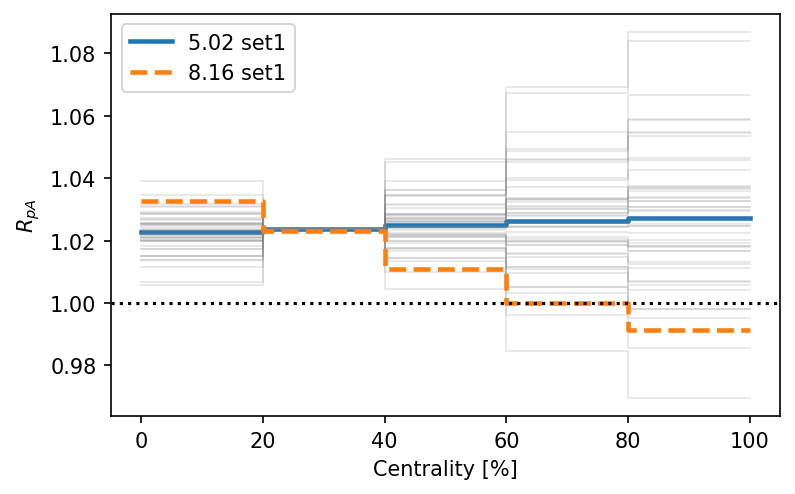

In [14]:
# Example plot (central set bold, members faint)
x5, R5 = RpA_vs_centrality("5.02", y_win=(-4.46,-2.96), pt_win=(1.5,20))
x8, R8 = RpA_vs_centrality("8.16", y_win=(-4.46,-2.96), pt_win=(1.5,20))

plt.figure(figsize=(5.4,3.4), dpi=150)
plt.step(CENT_EDGES, np.r_[R5[0], R5[0,-1]], where="post", lw=2.2, label="5.02 set1")
for k in range(1,49): plt.step(CENT_EDGES, np.r_[R5[k], R5[k,-1]], where="post", color="gray", alpha=0.2, lw=0.8)
plt.step(CENT_EDGES, np.r_[R8[0], R8[0,-1]], where="post", lw=2.2, ls="--", label="8.16 set1")
plt.axhline(1.0, ls=":", c="k"); plt.xlabel("Centrality [%]"); plt.ylabel(r"$R_{pA}$"); plt.legend(); plt.tight_layout()

In [15]:
def RpA_vs_y_in_cent(energy="5.02", cent_bin=(0,20), pt_fix=2.0):
    R0  = R0_5 if energy=="5.02" else R0_8
    prov= prov5 if energy=="5.02" else prov8
    abar= abar5 if energy=="5.02" else abar8
    # ⟨α⟩ for this bin
    i = list(zip(CENT_EDGES[:-1], CENT_EDGES[1:])).index(cent_bin)
    a = abar[i]
    y = np.linspace(-5,5,81)
    pt = np.full_like(y, pt_fix, float)
    R0_y = R0(y, pt)                                # (49, Ny)
    K0, Kf = K_anchors(prov, y, pt)                 # (49, Ny)
    RpA_y = R0_y * (Kf + (K0 - Kf)*a)               # (49, Ny)
    return y, RpA_y

def RpA_vs_pt_in_cent(energy="5.02", cent_bin=(0,20), y_fix=-3.5):
    R0  = R0_5 if energy=="5.02" else R0_8
    prov= prov5 if energy=="5.02" else prov8
    abar= abar5 if energy=="5.02" else abar8
    i = list(zip(CENT_EDGES[:-1], CENT_EDGES[1:])).index(cent_bin)
    a = abar[i]
    pt = np.linspace(0,20,81)
    y  = np.full_like(pt, y_fix, float)
    R0_p = R0(y, pt)                                # (49, Np)
    K0, Kf = K_anchors(prov, y, pt)                 # (49, Np)
    RpA_p = R0_p * (Kf + (K0 - Kf)*a)               # (49, Np)
    return pt, RpA_p

# # Example: centrality 40–60%
# yy, Ryy5 = RpA_vs_y_in_cent("5.02", (40,60), pt_fix=2.5)
# plt.figure(figsize=(5,3.2), dpi=140)
# plt.plot(yy, Ryy5[0], lw=2.2, label="set1")
# for k in range(1,49): plt.plot(yy, Ryy5[k], color="gray", alpha=0.2, lw=0.8)
# plt.axhline(1.0, ls=":", c="k"); plt.xlabel("y"); plt.ylabel(r"$R_{pA}$"); plt.legend(); plt.tight_layout()


In [16]:
def hessian_sym(members_48xN, cl=90):
    M = np.asarray(members_48xN, float)
    if M.shape[0] % 2 != 0:  # fallback
        delta = 0.5*(np.nanmax(M,0)-np.nanmin(M,0))
    else:
        d2 = np.zeros(M.shape[1])
        for i in range(0, M.shape[0], 2):
            diff = M[i] - M[i+1]
            d2  += diff*diff
        delta = 0.5*np.sqrt(d2)
    return delta/1.645 if cl==68 else delta

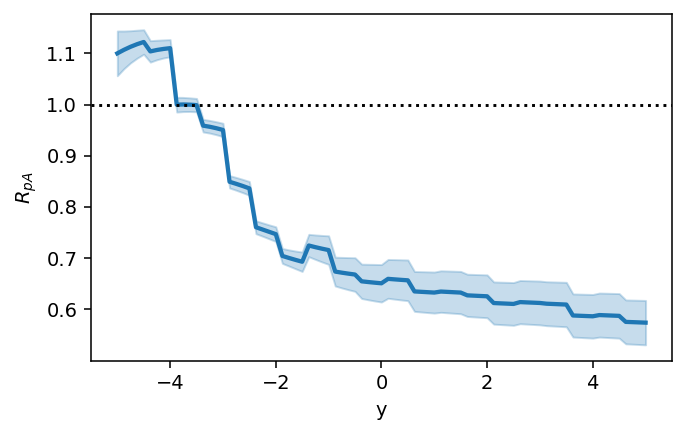

In [17]:
# Example: add band to RpA vs y in a bin
y, RpA_sets = RpA_vs_y_in_cent("5.02", (0,20), pt_fix=2.5)
Rc = RpA_sets[0]
band = hessian_sym(RpA_sets[1:], cl=90)
plt.figure(figsize=(5,3.2), dpi=140)
plt.plot(y, Rc, lw=2.2, color="tab:blue")
plt.fill_between(y, Rc-band, Rc+band, color="tab:blue", alpha=0.25)
plt.axhline(1.0, ls=":", c="k"); plt.xlabel("y"); plt.ylabel(r"$R_{pA}$"); plt.tight_layout()

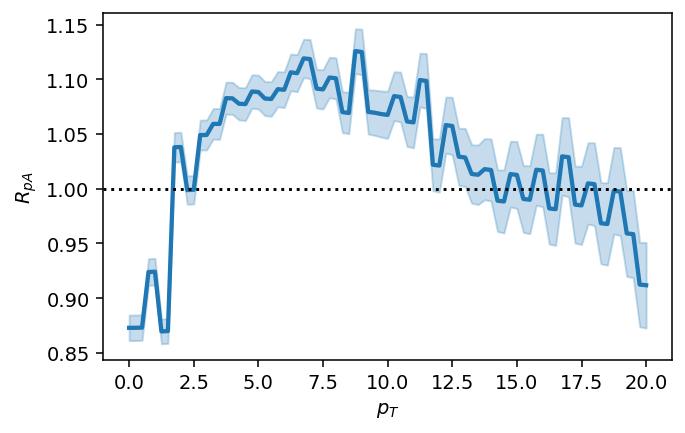

In [18]:
# Example: add band to RpA vs y in a bin
pt, RpA_sets = RpA_vs_pt_in_cent("5.02", (0,20), y_fix=-3.5)
Rc = RpA_sets[0]
band = hessian_sym(RpA_sets[1:], cl=90)
plt.figure(figsize=(5,3.2), dpi=140)
plt.plot(pt, Rc, lw=2.2, color="tab:blue")
plt.fill_between(pt, Rc-band, Rc+band, color="tab:blue", alpha=0.25)
plt.axhline(1.0, ls=":", c="k"); plt.xlabel(r"$p_T$"); plt.ylabel(r"$R_{pA}$"); plt.tight_layout()